In [26]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import osmnx as ox

# RAIL

### Import station name from TfL feed, joined spatially

In [3]:
# Download station location live feed from TFL
import urllib.request, json

try:
    url = "https://api.tfl.gov.uk/stationdata/tfl-stationdata-detailed.zip"

    hdr ={
    # Request headers
    }

    req = urllib.request.Request(url, headers=hdr)

    req.get_method = lambda: 'GET'
    response = urllib.request.urlopen(req)
    # download
    with open('data/tfl-stationdata-detailed.zip', 'wb') as f:
        f.write(response.read())
        
except Exception as e:
    print(e)


<urlopen error [SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1000)>


In [4]:
# unzip the file
import zipfile
with zipfile.ZipFile('data/tfl-stationdata-detailed.zip', 'r') as zip_ref:
    zip_ref.extractall('data/tfl-stationdata-detailed') 

In [5]:
# read Stations.csv
stations = pd.read_csv('data/tfl-stationdata-detailed/Stations.csv')
stations.head()

,UniqueId,Name,FareZones,HubNaptanCode,Wifi,OutsideStationUniqueId,BlueBadgeCarParking,BlueBadgeCarParkSpaces,TaxiRanksOutsideStation,MainBusInterchange,PierInterchange,NationalRailInterchange,AirportInterchange,EmiratesAirLineInterchange
0,HUBABW,Abbey Wood,4,HUBABW,False,HUBABW-Outside,False,NaN,False,NaN,NaN,NaN,NaN,NaN
1,910GACTNCTL,Acton Central,3,NaN,True,910GACTNCTL-Outside,False,NaN,False,NaN,NaN,NaN,NaN,NaN
2,910GACTONML,Acton Main Line,3,NaN,False,910GACTONML-Outside,False,NaN,False,NaN,NaN,NaN,NaN,NaN
3,910GANERLEY,Anerley,4,NaN,True,910GANERLEY-Outside,False,NaN,False,NaN,NaN,NaN,NaN,NaN
4,910GBCKNHMH,Beckenham Hill,4,NaN,False,910GBCKNHMH-Outside,False,NaN,False,NaN,NaN,NaN,NaN,NaN


In [6]:
# read StationPoints.csv
station_pt = pd.read_csv('data/tfl-stationdata-detailed/StationPoints.csv')
station_pt.head()

,UniqueId,StationUniqueId,AreaName,AreaId,Level,Lat,Lon,FriendlyName
0,910GACTNCTL-1001002-AC-3,910GACTNCTL,AC,3,0,51.50862,-0.26351,AC
1,910GACTNCTL-1001002-Bus-1,910GACTNCTL,Bus,1,0,51.50651,-0.26372,Bus
2,910GACTNCTL-1001002-ENTR-7,910GACTNCTL,ENTR,7,0,51.50892,-0.26260,ENTR
3,910GACTNCTL-1001002-RLY-4,910GACTNCTL,RLY,4,1,51.50865,-0.26293,RLY
4,910GACTNCTL-1001002-RPL-2,910GACTNCTL,RPL,2,1,51.50865,-0.26306,RPL


In [7]:
# Iterate through UniqueId from stations df, and extract mean lat and lon from station_pt df
for station in stations.UniqueId:
    lat = station_pt[station_pt.StationUniqueId==station].Lat.mean()
    lon = station_pt[station_pt.StationUniqueId==station].Lon.mean()
    # update stations df
    stations.loc[stations.UniqueId==station, 'Lat'] = lat
    stations.loc[stations.UniqueId==station, 'Lon'] = lon
    # geo data frame
    stations = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations['Lon'], stations['Lat']), crs='EPSG:4326')

# drop columns
stations = stations[['UniqueId', 'Name', 'geometry']]
stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   UniqueId  509 non-null    object  
 1   Name      509 non-null    object  
 2   geometry  509 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 12.1+ KB


In [8]:
# # change to dataframe
# stations_df = pd.DataFrame(stations)
# # Export stations
# stations_df.to_csv('data/stations_geo.csv', index=False)

### Import NUMBAT

In [9]:
# # read numbat data
# file = os.path.join('data', 'numbat','numbat_outputs','NBT22SAT_Outputs.csv')
# numbat = pd.read_csv(file)
# numbat.info()

Merging Hub stations

In [10]:
# # extract rows that contain LU, LO DLR, NR, EL in the Station column but not Bethnal Green and West Hampstead
# numbat_hub = numbat[~numbat['Station'].str.contains('Bethnal Green|West Hampstead', regex=True)]
# numbat_hub = numbat_hub[numbat_hub['Station'].str.contains('LU|LO|DLR|NR|EL', regex=True)]
# #create new column with Station value minus 3 characters to the right,trim space
# numbat_hub['Station_hub'] = numbat_hub['Station'].str[:-3].str.strip()
# print(numbat_hub.shape)

# #group by Station_hub and sum the values
# numbat_hub = numbat_hub.groupby('Station_hub').sum().reset_index()
# # #drop Station column, rename Station_hub to Station
# numbat_hub = numbat_hub.rename(columns={'Station':'Old_Station'})
# numbat_hub = numbat_hub.rename(columns={'Station_hub':'Station'})
# print(numbat_hub.shape)

# # Filter numbat for Station without LU, LO DLR, NR, EL in the Station column or if contains Bethnal Green or West Hampstead
# numbat_nonhub = numbat[~numbat['Station'].str.contains('LU|LO|DLR|NR|EL', regex=True)]
# print(numbat_nonhub.shape)
# numbat_nonhub_bth_west = numbat[numbat['Station'].str.contains('Bethnal Green|West Hampstead', regex=True)]
# print(numbat_nonhub_bth_west.shape)

# # concatenate numbat_hub and numbat_new
# numbat_merge = pd.concat([numbat_hub, numbat_nonhub, numbat_nonhub_bth_west], axis=0)
# # remove LU from Station column
# numbat_merge['Station'] = numbat_merge['Station'].str.replace('LU', '')
# print(numbat_merge.shape)

In [11]:
# # Explore merged numbat
# numbat_merge.to_csv('data/numbat_merge.csv', index=False)

### Import merged  file, reconciled NUMBAT + STATION LOCATIONS

In [34]:
# import 
numbat_merge_geo = pd.read_csv(os.path.join('data','numbat_geo_merge.csv'), delimiter=',')

# merge into stations df
numbat_merge_geo = numbat_merge_geo.drop(columns='geometry') # drop geometry column
stations_numbat_geo = stations[['UniqueId','geometry']].merge(numbat_merge_geo, left_on='UniqueId', right_on='UniqueId', how='inner')
stations_numbat_geo.to_crs(epsg=27700, inplace=True) 
stations_numbat_geo.head()

,UniqueId,geometry,Name,Total,Early,AM Peak,Midday,PM Peak,Evening,Late
0,HUBABW,POINT (547362.001 179062.289),Abbey Wood,16258.0,151.0,1422.0,5519,4046.0,3119.0,2001.0
1,910GACTNCTL,POINT (520636.152 180255.972),Acton Central,1997.0,7.0,164.0,730,593.0,327.0,176.0
2,910GACTONML,POINT (520282.791 181216.105),Acton Main Line,1416.0,92.0,96.0,349,350.0,278.0,251.0
3,910GANERLEY,POINT (534625.501 169925.992),Anerley,1022.0,5.0,57.0,267,250.0,231.0,212.0
4,910GBHILLPK,POINT (533698.968 195404.457),Bush Hill Park,1305.0,6.0,95.0,395,361.0,272.0,177.0


In [35]:
# filter out stations value 0
stations_numbat_geo = stations_numbat_geo[stations_numbat_geo['Total']!=0]
stations_numbat_geo.explore()

In [37]:
# download the Greater London boundary
greater_london = ox.geocode_to_gdf('Greater London, UK')
greater_london.to_crs(epsg=27700, inplace=True)

# subset points that are within the boundary of london
stations_numbat_geo = stations_numbat_geo[stations_numbat_geo.geometry.intersects(greater_london.geometry[0])]

In [38]:
stations_numbat_geo

,UniqueId,geometry,Name,Total,Early,AM Peak,Midday,PM Peak,Evening,Late
0,HUBABW,POINT (547362.001 179062.289),Abbey Wood,16258.0,151.0,1422.0,5519,4046.0,3119.0,2001.0
1,910GACTNCTL,POINT (520636.152 180255.972),Acton Central,1997.0,7.0,164.0,730,593.0,327.0,176.0
2,910GACTONML,POINT (520282.791 181216.105),Acton Main Line,1416.0,92.0,96.0,349,350.0,278.0,251.0
3,910GANERLEY,POINT (534625.501 169925.992),Anerley,1022.0,5.0,57.0,267,250.0,231.0,212.0
4,910GBHILLPK,POINT (533698.968 195404.457),Bush Hill Park,1305.0,6.0,95.0,395,361.0,272.0,177.0
...,...,...,...,...,...,...,...,...,...,...
450,HUBZWL,POINT (534705.351 181853.939),Whitechapel,18778.0,412.0,2173.0,7086,4253.0,3142.0,1712.0
451,940GZZNEUGST,POINT (530059.152 177316.704),Nine Elms,4450.0,55.0,283.0,1198,1196.0,1048.0,670.0
452,940GZZBPSUST,POINT (529139.242 177310.892),Battersea Power Station,21338.0,150.0,1464.0,12261,4927.0,1790.0,747.0
453,910GWOLWXR,POINT (543846.298 179026.270),Woolwich,14013.0,114.0,906.0,4559,3699.0,2888.0,1847.0


Text(0.5, 1.0, 'Total Exit flow - TfL Rail')

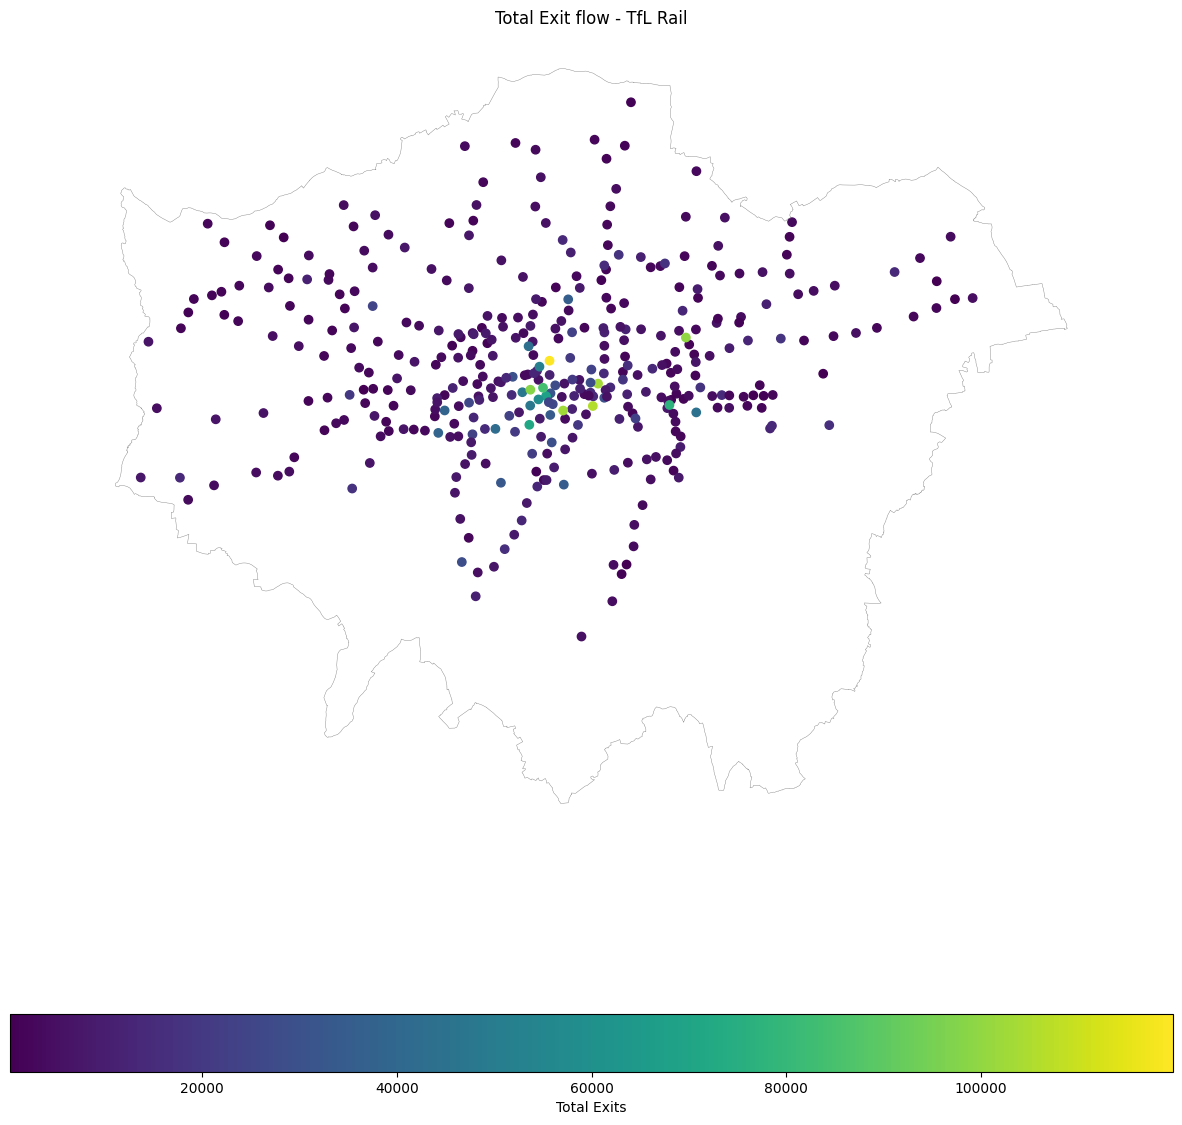

In [39]:
# plot stations_numbat_geo based on Total

fig,ax = plt.subplots(1,1,figsize=(15,15))
stations_numbat_geo.plot(column='Total',ax=ax,legend=True,legend_kwds={'label': "Total Exits",'orientation': "horizontal"})
greater_london.boundary.plot(ax=ax, color='grey', linewidth=0.3)
ax.set_axis_off()
plt.title('Total Exit flow - TfL Rail')

In [40]:
stations_numbat_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 389 entries, 0 to 454
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   UniqueId    389 non-null    object  
 1   geometry    389 non-null    geometry
 2   Name        389 non-null    object  
 3   Total       389 non-null    float64 
 4   Early       389 non-null    float64 
 5   AM Peak     389 non-null    float64 
 6   Midday      389 non-null    int64   
 7   PM Peak     389 non-null    float64 
 8   Evening     389 non-null    float64 
 9   Late        389 non-null    float64 
dtypes: float64(6), geometry(1), int64(1), object(2)
memory usage: 33.4+ KB


In [41]:
# Export stations_numbat_geo TO GEOJSON ESPG:27700
stations_numbat_geo.to_file('data/cleaned/flow_rail.geojson', driver='GeoJSON')